### To run the cbgt network, see first the technical_testbench to install all the required packages and start the server 

In [2]:
#Auto reloading 
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [3]:
#Removing indentation issues:
#!autopep8 --in-place --aggressive --aggressive init_params.py
#!autopep8 --in-place --aggressive --aggressive popconstruct.py
#!autopep8 --in-place --aggressive --aggressive generateepochs.py
#!autopep8 --in-place --aggressive --aggressive qvalues.py

In [4]:
!python setup.py build_ext --inplace

running build_ext
copying build/lib.macosx-10.9-x86_64-3.8/agent_timestep.cpython-38-darwin.so -> 


In [5]:
#Importing scripts:
import cbgt as cbgt
from frontendhelpers import * 
from tracetype import *
import init_params as par 
import popconstruct as popconstruct
import qvalues as qval
import generateepochs as gen
import generate_stop_dataframe as gen_stop
from agentmatrixinit import *
#from general_init_codeblocks import *
from agent_timestep import timestep_mutator, multitimestep_mutator
import pdb
import pipeline_creation as pl_creat
import mega_loop as ml
import plotting_functions as plt_func
import plotting_helper_functions as plt_help
import matplotlib.pyplot as plt

data_dir = "./Stop/"
figure_dir = "./Stop/"

2021-12-07 14:43:30,757	INFO worker.py:726 -- Connecting to existing Ray cluster at address: 192.168.1.50:6379


# Create pipeline

### Network pipeline

In [6]:
seed = np.random.randint(0,9999999)
#seed = 7915966
print(seed)
np.random.seed(seed)
to_check = np.random.randint(0,50,10)
print(to_check)

1947357
[22 26 48 14 20 37 35 20 10 23]


In [7]:
#Create the whole pipeline.
#This pipeline creates three sub-pipelines: 
#rewards pipeline (rsg), q values pipeline (q_val), network pipeline(pl), stop pipeline (stop)

pl = pl_creat.create_main_pipeline()
mega_l = ml.mega_loop

# Timestep loop

In [8]:
#Adding the timestep loop to the main pipeline
pl.add(mega_l)

# Running the pipeline

### 1. Stopping performance

### 1.1 Amplitude 

In [32]:
percentage = []
ampl_values = []
meantrialSTN = []
meantrialTh = []
meantrialsSTN_tot = []
meantrialsTh_tot = []

for amplitude in np.arange(0,3.75,0.25):
    
    meantrialSTN = []
    meantrialTh = []
    
    environment = {
    'params': None, #neuron parameters (init_params.py)
    'pops': None,   #population parameters (init_params.py)
    'receps' : None, #receptor parameters (init_params.py)
    'base' : None, #baseline stimulation parameters (init_params.py)
    'dpmns' : None, #dopamine related parameters (init_params.py)
    'd1' : None, #D1-MSNs population related parameters (init_params.py)
    'd2' : None, #D2-MSNs population related parameters (init_params.py)
    'channels' : pd.DataFrame([["left"],["right"]], columns=['action']), #action channels related parameters (init_params.py)
    #'actionchannels' : pd.DataFrame([[1],[2]], columns=['action']), #labels for the actions (init_params.py)
    #'actionchannels' : pd.DataFrame([["left"],["right"]], columns=['action']), #labels for the actions (init_params.py)
    'newpathways' : None, #connectivity parameters (popconstruct.py)
    'Q_support_params': None, #initialization of Q-values update (qvalues.py) 
    'Q_df':None, #initialized Q-values df (qvalues.py)  
    'n_trials': 3, #number of trials (generateepochs.py)
    'volatility': 1, #frequency of changepoints (generateepochs.py)
    'conflict': 0.7, #probability of the preferred choice (generateepochs.py)
    'reward_mu': 1, #mean for the magnitude of the reward (generateepochs.py)
    'reward_std': 0.1, #std for the magnitude of the reward (generateepochs.py)
    'maxstim': 3.5, # 3 instead? how much stimulus the LIP gets at maximum
    'sustainedfraction': 0.75,
    'stop_signal_present': True,
    'stop_signal_probability': 1.0, #probability of trials that will get the stop signal / list of trial numbers
    'stop_signal_amplitude': amplitude, #amplitude #amplitude of the stop signal over base line
    'stop_signal_onset': 40., #in ms #antes 200
    'stop_signal_channel': "all", #"all" (all channels are given the stop signal) 
                                #/"any" (channel given the stop signal is chosen randomly)
                                # [list of channels] == subset of channels given the stop signal
    }
    
    results = cbgt.ExecutionManager(cores=7).run([pl]*1,[environment]*1)
    
    datatables = cbgt.collateVariable(results,'datatables')
    stop_number = 0
    for i in datatables[0].index:
        if datatables[0].iloc[i]['decision'] == 'stop': 
            stop_number += 1
    percentage.append(stop_number/results[0]['n_trials'])
    #for i in range(0, len(datatables[0].stimulusstarttime)):
    for i in datatables[0].index:
        if datatables[0].iloc[i]['decision'] == 'stop':#quitar solo if statement 
            meantrialSTN.append([np.mean(results[0]['popfreqs'][2][datatables[0].stimulusstarttime[i]+40:datatables[0].decisiontime[i]]), (np.mean(results[0]['popfreqs'][3][datatables[0].stimulusstarttime[i]+40:datatables[0].decisiontime[i]]))])
            meantrialTh.append([np.mean(results[0]['popfreqs'][12][datatables[0].stimulusstarttime[i]+40:datatables[0].decisiontime[i]]), (np.mean(results[0]['popfreqs'][13][datatables[0].stimulusstarttime[i]+40:datatables[0].decisiontime[i]]))])
        else: #quitar 
            meantrialSTN.append([0, 0])
            meantrialTh.append([0, 0])
    meantrialsSTN_tot.append(np.mean(meantrialSTN, axis = 0))
    meantrialsTh_tot.append(np.mean(meantrialTh, axis = 0))
    ampl_values.append(amplitude)
    cbgt.saveResults(results, data_dir+'stop_data_ampl_'+str(amplitude)+'_'+str(seed),['popfreqs','popdata'])
    firing_rates, q_df, performance, rt_distribution, total_performance = plt_help.extract_relevant_frames(results,seed)
    #plt_func.plot_fr_stop(firing_rates, amplitude, results[0]['stop_signal_onset'])

(pid=4045) cp_idx [0 2 3 4 2]
(pid=4045) cp_idx [0 2 2]
(pid=4045) begin GenStopSchedule
(pid=4045) <class 'float'>
(pid=4045) [0 2 1]
(pid=4045) stop_df
(pid=4045)    stop_signal_present  stop_signal_probability stop_signal_channel
(pid=4045) 0                 True                      1.0                 all
(pid=4045) stop_channels_df
(pid=4045)    left  right  trial_num
(pid=4045) 0  True   True          0
(pid=4045) 1  True   True          1
(pid=4045) 2  True   True          2
(pid=4045) cp_idx [0 2 3 4 2]
(pid=4045) cp_idx [0 2 2]
(pid=4045) begin GenStopSchedule
(pid=4045) <class 'float'>
(pid=4045) [0 2 1]
(pid=4045) stop_df
(pid=4045)    stop_signal_present  stop_signal_probability stop_signal_channel
(pid=4045) 0                 True                      1.0                 all
(pid=4045) stop_channels_df
(pid=4045)    left  right  trial_num
(pid=4045) 0  True   True          0
(pid=4045) 1  True   True          1
(pid=4045) 2  True   True          2
(pid=4045) q_support Non

(pid=4045) 0 stopsignal_applied [1. 0.]
(pid=4045) 0 agent.ramping_stopstim_target [4.45 4.45]
(pid=4045) 0 agent.stoptimer 40
(pid=4045) 0 trial_wise_stop_amplitude 0.0
(pid=4045) 0 trial_wise_stop_onset 40.0
(pid=4045) 0 agent.phase 0
(pid=4045) 0 stopsignal_applied [1. 1.]
(pid=4045) 0 agent.ramping_stopstim_target [4.45 4.45]
(pid=4045) 0 agent.stoptimer 40
(pid=4045) 0 trial_wise_stop_amplitude 0.0
(pid=4045) 0 trial_wise_stop_onset 40.0
(pid=4045) 0 agent.phase 0
(pid=4045) 0 stopsignal_applied [1. 0.]
(pid=4045) 0 agent.ramping_stopstim_target [4.45 4.45]
(pid=4045) 0 agent.stoptimer 40
(pid=4045) 0 trial_wise_stop_amplitude 0.0
(pid=4045) 0 trial_wise_stop_onset 40.0
(pid=4045) 0 agent.phase 0
(pid=4045) 0 stopsignal_applied [1. 1.]
(pid=4045) 0 agent.ramping_stopstim_target [4.45 4.45]
(pid=4045) 0 agent.stoptimer 40
(pid=4045) 0 trial_wise_stop_amplitude 0.0
(pid=4045) 0 trial_wise_stop_onset 40.0
(pid=4045) 0 agent.phase 0
(pid=4045) phasetimer 120
(pid=4045) globaltimer 112

(pid=4045) q_support None
(pid=4045) q_support None
(pid=4045) 2 4 0.161666`
(pid=4045) 2 4 0.161666`
(pid=4045) 3 5 0.161666`
(pid=4045) 10 6 1.0`
(pid=4045) 10 8 1.0`
(pid=4045) 3 5 0.161666`
(pid=4045) 10 6 1.0`
(pid=4045) 10 8 1.0`
(pid=4045) 10 10 0.4335`
(pid=4045) 10 12 1.0`
(pid=4045) 10 14 1.0`
(pid=4045) 10 10 0.4335`
(pid=4045) 10 12 1.0`
(pid=4045) 10 14 1.0`
(pid=4045) 10 15 0.241667`
(pid=4045) 11 7 1.0`
(pid=4045) 11 9 1.0`
(pid=4045) 10 15 0.241667`
(pid=4045) 11 7 1.0`
(pid=4045) 11 9 1.0`
(pid=4045) 11 11 0.4335`
(pid=4045) 11 13 1.0`
(pid=4045) 11 14 1.0`
(pid=4045) 11 11 0.4335`
(pid=4045) 11 13 1.0`
(pid=4045) 11 14 1.0`
(pid=4045) 11 15 0.241667`
(pid=4045) 12 6 1.0`
(pid=4045) 12 8 1.0`
(pid=4045) 12 14 0.8334`
(pid=4045) 13 7 1.0`
(pid=4045) 13 9 1.0`
(pid=4045) 13 14 0.8334`
(pid=4045) 0 12 1.0`
(pid=4045) 1 13 1.0`
(pid=4045) 4 0 1.0`
(pid=4045) 11 15 0.241667`
(pid=4045) 12 6 1.0`
(pid=4045) 12 8 1.0`
(pid=4045) 12 14 0.8334`
(pid=4045) 13 7 1.0`
(pid=4045) 1

(pid=4045) 0 stopsignal_applied [1. 0.]
(pid=4045) 0 agent.ramping_stopstim_target [4.7  4.45]
(pid=4045) 0 agent.stoptimer 40
(pid=4045) 0 trial_wise_stop_amplitude 0.25
(pid=4045) 0 trial_wise_stop_onset 40.0
(pid=4045) 0 agent.phase 0
(pid=4045) 0 stopsignal_applied [1. 1.]
(pid=4045) 0 agent.ramping_stopstim_target [4.7 4.7]
(pid=4045) 0 agent.stoptimer 40
(pid=4045) 0 trial_wise_stop_amplitude 0.25
(pid=4045) 0 trial_wise_stop_onset 40.0
(pid=4045) 0 agent.phase 0
(pid=4045) 0 stopsignal_applied [1. 0.]
(pid=4045) 0 agent.ramping_stopstim_target [4.7  4.45]
(pid=4045) 0 agent.stoptimer 40
(pid=4045) 0 trial_wise_stop_amplitude 0.25
(pid=4045) 0 trial_wise_stop_onset 40.0
(pid=4045) 0 agent.phase 0
(pid=4045) 0 stopsignal_applied [1. 1.]
(pid=4045) 0 agent.ramping_stopstim_target [4.7 4.7]
(pid=4045) 0 agent.stoptimer 40
(pid=4045) 0 trial_wise_stop_amplitude 0.25
(pid=4045) 0 trial_wise_stop_onset 40.0
(pid=4045) 0 agent.phase 0
(pid=4045) phasetimer 89
(pid=4045) globaltimer 1085

(pid=4045) q_support None
(pid=4045) q_support None
(pid=4045) 2 4 0.161666`
(pid=4045) 2 4 0.161666`
(pid=4045) 3 5 0.161666`
(pid=4045) 10 6 1.0`
(pid=4045) 10 8 1.0`
(pid=4045) 3 5 0.161666`
(pid=4045) 10 6 1.0`
(pid=4045) 10 8 1.0`
(pid=4045) 10 10 0.4335`
(pid=4045) 10 12 1.0`
(pid=4045) 10 14 1.0`
(pid=4045) 10 10 0.4335`
(pid=4045) 10 12 1.0`
(pid=4045) 10 14 1.0`
(pid=4045) 10 15 0.241667`
(pid=4045) 11 7 1.0`
(pid=4045) 11 9 1.0`
(pid=4045) 10 15 0.241667`
(pid=4045) 11 7 1.0`
(pid=4045) 11 9 1.0`
(pid=4045) 11 11 0.4335`
(pid=4045) 11 13 1.0`
(pid=4045) 11 14 1.0`
(pid=4045) 11 11 0.4335`
(pid=4045) 11 13 1.0`
(pid=4045) 11 14 1.0`
(pid=4045) 11 15 0.241667`
(pid=4045) 12 6 1.0`
(pid=4045) 12 8 1.0`
(pid=4045) 11 15 0.241667`
(pid=4045) 12 6 1.0`
(pid=4045) 12 8 1.0`
(pid=4045) 12 14 0.8334`
(pid=4045) 13 7 1.0`
(pid=4045) 13 9 1.0`
(pid=4045) 13 14 0.8334`
(pid=4045) 0 12 1.0`
(pid=4045) 1 13 1.0`
(pid=4045) 4 0 1.0`
(pid=4045) 12 14 0.8334`
(pid=4045) 13 7 1.0`
(pid=4045) 1

(pid=4045) 0 stopsignal_applied [1. 0.]
(pid=4045) 0 agent.ramping_stopstim_target [4.95 4.45]
(pid=4045) 0 agent.stoptimer 40
(pid=4045) 0 trial_wise_stop_amplitude 0.5
(pid=4045) 0 trial_wise_stop_onset 40.0
(pid=4045) 0 agent.phase 0
(pid=4045) 0 stopsignal_applied [1. 1.]
(pid=4045) 0 agent.ramping_stopstim_target [4.95 4.95]
(pid=4045) 0 agent.stoptimer 40
(pid=4045) 0 trial_wise_stop_amplitude 0.5
(pid=4045) 0 trial_wise_stop_onset 40.0
(pid=4045) 0 agent.phase 0
(pid=4045) 0 stopsignal_applied [1. 0.]
(pid=4045) 0 agent.ramping_stopstim_target [4.95 4.45]
(pid=4045) 0 agent.stoptimer 40
(pid=4045) 0 trial_wise_stop_amplitude 0.5
(pid=4045) 0 trial_wise_stop_onset 40.0
(pid=4045) 0 agent.phase 0
(pid=4045) 0 stopsignal_applied [1. 1.]
(pid=4045) 0 agent.ramping_stopstim_target [4.95 4.95]
(pid=4045) 0 agent.stoptimer 40
(pid=4045) 0 trial_wise_stop_amplitude 0.5
(pid=4045) 0 trial_wise_stop_onset 40.0
(pid=4045) 0 agent.phase 0
(pid=4045) phasetimer 85
(pid=4045) globaltimer 1145

(pid=4045) q_support None
(pid=4045) q_support None
(pid=4045) 2 4 0.161666`
(pid=4045) 2 4 0.161666`
(pid=4045) 3 5 0.161666`
(pid=4045) 10 6 1.0`
(pid=4045) 10 8 1.0`
(pid=4045) 3 5 0.161666`
(pid=4045) 10 6 1.0`
(pid=4045) 10 8 1.0`
(pid=4045) 10 10 0.4335`
(pid=4045) 10 12 1.0`
(pid=4045) 10 14 1.0`
(pid=4045) 10 10 0.4335`
(pid=4045) 10 12 1.0`
(pid=4045) 10 14 1.0`
(pid=4045) 10 15 0.241667`
(pid=4045) 11 7 1.0`
(pid=4045) 11 9 1.0`
(pid=4045) 10 15 0.241667`
(pid=4045) 11 7 1.0`
(pid=4045) 11 9 1.0`
(pid=4045) 11 11 0.4335`
(pid=4045) 11 13 1.0`
(pid=4045) 11 14 1.0`
(pid=4045) 11 11 0.4335`
(pid=4045) 11 13 1.0`
(pid=4045) 11 14 1.0`
(pid=4045) 11 15 0.241667`
(pid=4045) 12 6 1.0`
(pid=4045) 12 8 1.0`
(pid=4045) 11 15 0.241667`
(pid=4045) 12 6 1.0`
(pid=4045) 12 8 1.0`
(pid=4045) 12 14 0.8334`
(pid=4045) 13 7 1.0`
(pid=4045) 13 9 1.0`
(pid=4045) 12 14 0.8334`
(pid=4045) 13 7 1.0`
(pid=4045) 13 9 1.0`
(pid=4045) 13 14 0.8334`
(pid=4045) 0 12 1.0`
(pid=4045) 1 13 1.0`
(pid=4045) 

(pid=4045) 0 stopsignal_applied [1. 0.]
(pid=4045) 0 agent.ramping_stopstim_target [5.2  4.45]
(pid=4045) 0 agent.stoptimer 40
(pid=4045) 0 trial_wise_stop_amplitude 0.75
(pid=4045) 0 trial_wise_stop_onset 40.0
(pid=4045) 0 agent.phase 0
(pid=4045) 0 stopsignal_applied [1. 1.]
(pid=4045) 0 agent.ramping_stopstim_target [5.2 5.2]
(pid=4045) 0 agent.stoptimer 40
(pid=4045) 0 trial_wise_stop_amplitude 0.75
(pid=4045) 0 trial_wise_stop_onset 40.0
(pid=4045) 0 agent.phase 0
(pid=4045) 0 stopsignal_applied [1. 0.]
(pid=4045) 0 agent.ramping_stopstim_target [5.2  4.45]
(pid=4045) 0 agent.stoptimer 40
(pid=4045) 0 trial_wise_stop_amplitude 0.75
(pid=4045) 0 trial_wise_stop_onset 40.0
(pid=4045) 0 agent.phase 0
(pid=4045) 0 stopsignal_applied [1. 1.]
(pid=4045) 0 agent.ramping_stopstim_target [5.2 5.2]
(pid=4045) 0 agent.stoptimer 40
(pid=4045) 0 trial_wise_stop_amplitude 0.75
(pid=4045) 0 trial_wise_stop_onset 40.0
(pid=4045) 0 agent.phase 0
(pid=4045) phasetimer 279
(pid=4045) globaltimer 133

(pid=4045) q_support None
(pid=4045) q_support None
(pid=4045) 2 4 0.161666`
(pid=4045) 2 4 0.161666`
(pid=4045) 3 5 0.161666`
(pid=4045) 3 5 0.161666`
(pid=4045) 10 6 1.0`
(pid=4045) 10 8 1.0`
(pid=4045) 10 6 1.0`
(pid=4045) 10 8 1.0`
(pid=4045) 10 10 0.4335`
(pid=4045) 10 12 1.0`
(pid=4045) 10 14 1.0`
(pid=4045) 10 10 0.4335`
(pid=4045) 10 12 1.0`
(pid=4045) 10 14 1.0`
(pid=4045) 10 15 0.241667`
(pid=4045) 11 7 1.0`
(pid=4045) 11 9 1.0`
(pid=4045) 10 15 0.241667`
(pid=4045) 11 7 1.0`
(pid=4045) 11 9 1.0`
(pid=4045) 11 11 0.4335`
(pid=4045) 11 13 1.0`
(pid=4045) 11 14 1.0`
(pid=4045) 11 11 0.4335`
(pid=4045) 11 13 1.0`
(pid=4045) 11 14 1.0`
(pid=4045) 11 15 0.241667`
(pid=4045) 12 6 1.0`
(pid=4045) 12 8 1.0`
(pid=4045) 12 14 0.8334`
(pid=4045) 13 7 1.0`
(pid=4045) 13 9 1.0`
(pid=4045) 11 15 0.241667`
(pid=4045) 12 6 1.0`
(pid=4045) 12 8 1.0`
(pid=4045) 12 14 0.8334`
(pid=4045) 13 7 1.0`
(pid=4045) 13 9 1.0`
(pid=4045) 13 14 0.8334`
(pid=4045) 0 12 1.0`
(pid=4045) 1 13 1.0`
(pid=4045) 

(pid=4045) 0 stopsignal_applied [1. 0.]
(pid=4045) 0 agent.ramping_stopstim_target [5.45 4.45]
(pid=4045) 0 agent.stoptimer 40
(pid=4045) 0 trial_wise_stop_amplitude 1.0
(pid=4045) 0 trial_wise_stop_onset 40.0
(pid=4045) 0 agent.phase 0
(pid=4045) 0 stopsignal_applied [1. 1.]
(pid=4045) 0 agent.ramping_stopstim_target [5.45 5.45]
(pid=4045) 0 agent.stoptimer 40
(pid=4045) 0 trial_wise_stop_amplitude 1.0
(pid=4045) 0 trial_wise_stop_onset 40.0
(pid=4045) 0 agent.phase 0
(pid=4045) 0 stopsignal_applied [1. 0.]
(pid=4045) 0 agent.ramping_stopstim_target [5.45 4.45]
(pid=4045) 0 agent.stoptimer 40
(pid=4045) 0 trial_wise_stop_amplitude 1.0
(pid=4045) 0 trial_wise_stop_onset 40.0
(pid=4045) 0 agent.phase 0
(pid=4045) 0 stopsignal_applied [1. 1.]
(pid=4045) 0 agent.ramping_stopstim_target [5.45 5.45]
(pid=4045) 0 agent.stoptimer 40
(pid=4045) 0 trial_wise_stop_amplitude 1.0
(pid=4045) 0 trial_wise_stop_onset 40.0
(pid=4045) 0 agent.phase 0
(pid=4045) phasetimer 185
(pid=4045) globaltimer 124

(pid=4045) q_support None
(pid=4045) q_support None
(pid=4045) 2 4 0.161666`
(pid=4045) 2 4 0.161666`
(pid=4045) 3 5 0.161666`
(pid=4045) 10 6 1.0`
(pid=4045) 10 8 1.0`
(pid=4045) 3 5 0.161666`
(pid=4045) 10 6 1.0`
(pid=4045) 10 8 1.0`
(pid=4045) 10 10 0.4335`
(pid=4045) 10 12 1.0`
(pid=4045) 10 14 1.0`
(pid=4045) 10 10 0.4335`
(pid=4045) 10 12 1.0`
(pid=4045) 10 14 1.0`
(pid=4045) 10 15 0.241667`
(pid=4045) 11 7 1.0`
(pid=4045) 11 9 1.0`
(pid=4045) 10 15 0.241667`
(pid=4045) 11 7 1.0`
(pid=4045) 11 9 1.0`
(pid=4045) 11 11 0.4335`
(pid=4045) 11 13 1.0`
(pid=4045) 11 14 1.0`
(pid=4045) 11 11 0.4335`
(pid=4045) 11 13 1.0`
(pid=4045) 11 14 1.0`
(pid=4045) 11 15 0.241667`
(pid=4045) 12 6 1.0`
(pid=4045) 12 8 1.0`
(pid=4045) 11 15 0.241667`
(pid=4045) 12 6 1.0`
(pid=4045) 12 8 1.0`
(pid=4045) 12 14 0.8334`
(pid=4045) 13 7 1.0`
(pid=4045) 13 9 1.0`
(pid=4045) 12 14 0.8334`
(pid=4045) 13 7 1.0`
(pid=4045) 13 9 1.0`
(pid=4045) 13 14 0.8334`
(pid=4045) 0 12 1.0`
(pid=4045) 1 13 1.0`
(pid=4045) 

(pid=4045) 0 stopsignal_applied [1. 0.]
(pid=4045) 0 agent.ramping_stopstim_target [5.7  4.45]
(pid=4045) 0 agent.stoptimer 40
(pid=4045) 0 trial_wise_stop_amplitude 1.25
(pid=4045) 0 trial_wise_stop_onset 40.0
(pid=4045) 0 agent.phase 0
(pid=4045) 0 stopsignal_applied [1. 1.]
(pid=4045) 0 agent.ramping_stopstim_target [5.7 5.7]
(pid=4045) 0 agent.stoptimer 40
(pid=4045) 0 trial_wise_stop_amplitude 1.25
(pid=4045) 0 trial_wise_stop_onset 40.0
(pid=4045) 0 agent.phase 0
(pid=4045) 0 stopsignal_applied [1. 0.]
(pid=4045) 0 agent.ramping_stopstim_target [5.7  4.45]
(pid=4045) 0 agent.stoptimer 40
(pid=4045) 0 trial_wise_stop_amplitude 1.25
(pid=4045) 0 trial_wise_stop_onset 40.0
(pid=4045) 0 agent.phase 0
(pid=4045) 0 stopsignal_applied [1. 1.]
(pid=4045) 0 agent.ramping_stopstim_target [5.7 5.7]
(pid=4045) 0 agent.stoptimer 40
(pid=4045) 0 trial_wise_stop_amplitude 1.25
(pid=4045) 0 trial_wise_stop_onset 40.0
(pid=4045) 0 agent.phase 0
(pid=4045) phasetimer 594
(pid=4045) globaltimer 191

(pid=4045) q_support None
(pid=4045) q_support None
(pid=4045) 2 4 0.161666`
(pid=4045) 2 4 0.161666`
(pid=4045) 3 5 0.161666`
(pid=4045) 10 6 1.0`
(pid=4045) 10 8 1.0`
(pid=4045) 3 5 0.161666`
(pid=4045) 10 6 1.0`
(pid=4045) 10 8 1.0`
(pid=4045) 10 10 0.4335`
(pid=4045) 10 12 1.0`
(pid=4045) 10 14 1.0`
(pid=4045) 10 10 0.4335`
(pid=4045) 10 12 1.0`
(pid=4045) 10 14 1.0`
(pid=4045) 10 15 0.241667`
(pid=4045) 11 7 1.0`
(pid=4045) 11 9 1.0`
(pid=4045) 10 15 0.241667`
(pid=4045) 11 7 1.0`
(pid=4045) 11 9 1.0`
(pid=4045) 11 11 0.4335`
(pid=4045) 11 13 1.0`
(pid=4045) 11 14 1.0`
(pid=4045) 11 11 0.4335`
(pid=4045) 11 13 1.0`
(pid=4045) 11 14 1.0`
(pid=4045) 11 15 0.241667`
(pid=4045) 12 6 1.0`
(pid=4045) 12 8 1.0`
(pid=4045) 11 15 0.241667`
(pid=4045) 12 6 1.0`
(pid=4045) 12 8 1.0`
(pid=4045) 12 14 0.8334`
(pid=4045) 13 7 1.0`
(pid=4045) 13 9 1.0`
(pid=4045) 13 14 0.8334`
(pid=4045) 0 12 1.0`
(pid=4045) 1 13 1.0`
(pid=4045) 4 0 1.0`
(pid=4045) 12 14 0.8334`
(pid=4045) 13 7 1.0`
(pid=4045) 1

(pid=4045) 0 stopsignal_applied [1. 0.]
(pid=4045) 0 agent.ramping_stopstim_target [5.95 4.45]
(pid=4045) 0 agent.stoptimer 40
(pid=4045) 0 trial_wise_stop_amplitude 1.5
(pid=4045) 0 trial_wise_stop_onset 40.0
(pid=4045) 0 agent.phase 0
(pid=4045) 0 stopsignal_applied [1. 1.]
(pid=4045) 0 agent.ramping_stopstim_target [5.95 5.95]
(pid=4045) 0 agent.stoptimer 40
(pid=4045) 0 trial_wise_stop_amplitude 1.5
(pid=4045) 0 trial_wise_stop_onset 40.0
(pid=4045) 0 agent.phase 0
(pid=4045) 0 stopsignal_applied [1. 0.]
(pid=4045) 0 agent.ramping_stopstim_target [5.95 4.45]
(pid=4045) 0 agent.stoptimer 40
(pid=4045) 0 trial_wise_stop_amplitude 1.5
(pid=4045) 0 trial_wise_stop_onset 40.0
(pid=4045) 0 agent.phase 0
(pid=4045) 0 stopsignal_applied [1. 1.]
(pid=4045) 0 agent.ramping_stopstim_target [5.95 5.95]
(pid=4045) 0 agent.stoptimer 40
(pid=4045) 0 trial_wise_stop_amplitude 1.5
(pid=4045) 0 trial_wise_stop_onset 40.0
(pid=4045) 0 agent.phase 0
(pid=4045) phasetimer 1001
(pid=4045) globaltimer 21

(pid=4045) q_support None
(pid=4045) q_support None
(pid=4045) 2 4 0.161666`
(pid=4045) 2 4 0.161666`
(pid=4045) 3 5 0.161666`
(pid=4045) 10 6 1.0`
(pid=4045) 10 8 1.0`
(pid=4045) 3 5 0.161666`
(pid=4045) 10 6 1.0`
(pid=4045) 10 8 1.0`
(pid=4045) 10 10 0.4335`
(pid=4045) 10 12 1.0`
(pid=4045) 10 14 1.0`
(pid=4045) 10 10 0.4335`
(pid=4045) 10 12 1.0`
(pid=4045) 10 14 1.0`
(pid=4045) 10 15 0.241667`
(pid=4045) 11 7 1.0`
(pid=4045) 11 9 1.0`
(pid=4045) 10 15 0.241667`
(pid=4045) 11 7 1.0`
(pid=4045) 11 9 1.0`
(pid=4045) 11 11 0.4335`
(pid=4045) 11 13 1.0`
(pid=4045) 11 14 1.0`
(pid=4045) 11 11 0.4335`
(pid=4045) 11 13 1.0`
(pid=4045) 11 14 1.0`
(pid=4045) 11 15 0.241667`
(pid=4045) 12 6 1.0`
(pid=4045) 12 8 1.0`
(pid=4045) 12 14 0.8334`
(pid=4045) 13 7 1.0`
(pid=4045) 13 9 1.0`
(pid=4045) 13 14 0.8334`
(pid=4045) 0 12 1.0`
(pid=4045) 1 13 1.0`
(pid=4045) 4 0 1.0`
(pid=4045) 11 15 0.241667`
(pid=4045) 12 6 1.0`
(pid=4045) 12 8 1.0`
(pid=4045) 12 14 0.8334`
(pid=4045) 13 7 1.0`
(pid=4045) 1

(pid=4045) 0 stopsignal_applied [1. 0.]
(pid=4045) 0 agent.ramping_stopstim_target [6.2  4.45]
(pid=4045) 0 agent.stoptimer 40
(pid=4045) 0 trial_wise_stop_amplitude 1.75
(pid=4045) 0 trial_wise_stop_onset 40.0
(pid=4045) 0 agent.phase 0
(pid=4045) 0 stopsignal_applied [1. 1.]
(pid=4045) 0 agent.ramping_stopstim_target [6.2 6.2]
(pid=4045) 0 agent.stoptimer 40
(pid=4045) 0 trial_wise_stop_amplitude 1.75
(pid=4045) 0 trial_wise_stop_onset 40.0
(pid=4045) 0 agent.phase 0
(pid=4045) 0 stopsignal_applied [1. 0.]
(pid=4045) 0 agent.ramping_stopstim_target [6.2  4.45]
(pid=4045) 0 agent.stoptimer 40
(pid=4045) 0 trial_wise_stop_amplitude 1.75
(pid=4045) 0 trial_wise_stop_onset 40.0
(pid=4045) 0 agent.phase 0
(pid=4045) 0 stopsignal_applied [1. 1.]
(pid=4045) 0 agent.ramping_stopstim_target [6.2 6.2]
(pid=4045) 0 agent.stoptimer 40
(pid=4045) 0 trial_wise_stop_amplitude 1.75
(pid=4045) 0 trial_wise_stop_onset 40.0
(pid=4045) 0 agent.phase 0
(pid=4045) phasetimer 1001
(pid=4045) globaltimer 29

(pid=4045) q_support None
(pid=4045) q_support None
(pid=4045) 2 4 0.161666`
(pid=4045) 2 4 0.161666`
(pid=4045) 3 5 0.161666`
(pid=4045) 10 6 1.0`
(pid=4045) 10 8 1.0`
(pid=4045) 3 5 0.161666`
(pid=4045) 10 6 1.0`
(pid=4045) 10 8 1.0`
(pid=4045) 10 10 0.4335`
(pid=4045) 10 12 1.0`
(pid=4045) 10 14 1.0`
(pid=4045) 10 10 0.4335`
(pid=4045) 10 12 1.0`
(pid=4045) 10 14 1.0`
(pid=4045) 10 15 0.241667`
(pid=4045) 11 7 1.0`
(pid=4045) 11 9 1.0`
(pid=4045) 10 15 0.241667`
(pid=4045) 11 7 1.0`
(pid=4045) 11 9 1.0`
(pid=4045) 11 11 0.4335`
(pid=4045) 11 13 1.0`
(pid=4045) 11 14 1.0`
(pid=4045) 11 11 0.4335`
(pid=4045) 11 13 1.0`
(pid=4045) 11 14 1.0`
(pid=4045) 11 15 0.241667`
(pid=4045) 12 6 1.0`
(pid=4045) 12 8 1.0`
(pid=4045) 12 14 0.8334`
(pid=4045) 13 7 1.0`
(pid=4045) 13 9 1.0`
(pid=4045) 13 14 0.8334`
(pid=4045) 0 12 1.0`
(pid=4045) 1 13 1.0`
(pid=4045) 4 0 1.0`
(pid=4045) 11 15 0.241667`
(pid=4045) 12 6 1.0`
(pid=4045) 12 8 1.0`
(pid=4045) 12 14 0.8334`
(pid=4045) 13 7 1.0`
(pid=4045) 1

(pid=4045) 0 stopsignal_applied [1. 0.]
(pid=4045) 0 agent.ramping_stopstim_target [6.45 4.45]
(pid=4045) 0 agent.stoptimer 40
(pid=4045) 0 trial_wise_stop_amplitude 2.0
(pid=4045) 0 trial_wise_stop_onset 40.0
(pid=4045) 0 agent.phase 0
(pid=4045) 0 stopsignal_applied [1. 1.]
(pid=4045) 0 agent.ramping_stopstim_target [6.45 6.45]
(pid=4045) 0 agent.stoptimer 40
(pid=4045) 0 trial_wise_stop_amplitude 2.0
(pid=4045) 0 trial_wise_stop_onset 40.0
(pid=4045) 0 agent.phase 0
(pid=4045) 0 stopsignal_applied [1. 0.]
(pid=4045) 0 agent.ramping_stopstim_target [6.45 4.45]
(pid=4045) 0 agent.stoptimer 40
(pid=4045) 0 trial_wise_stop_amplitude 2.0
(pid=4045) 0 trial_wise_stop_onset 40.0
(pid=4045) 0 agent.phase 0
(pid=4045) 0 stopsignal_applied [1. 1.]
(pid=4045) 0 agent.ramping_stopstim_target [6.45 6.45]
(pid=4045) 0 agent.stoptimer 40
(pid=4045) 0 trial_wise_stop_amplitude 2.0
(pid=4045) 0 trial_wise_stop_onset 40.0
(pid=4045) 0 agent.phase 0
(pid=4045) phasetimer 1001
(pid=4045) globaltimer 29

(pid=4045) q_support None
(pid=4045) q_support None
(pid=4045) 2 4 0.161666`
(pid=4045) 2 4 0.161666`
(pid=4045) 3 5 0.161666`
(pid=4045) 10 6 1.0`
(pid=4045) 10 8 1.0`
(pid=4045) 3 5 0.161666`
(pid=4045) 10 6 1.0`
(pid=4045) 10 8 1.0`
(pid=4045) 10 10 0.4335`
(pid=4045) 10 12 1.0`
(pid=4045) 10 14 1.0`
(pid=4045) 10 10 0.4335`
(pid=4045) 10 12 1.0`
(pid=4045) 10 14 1.0`
(pid=4045) 10 15 0.241667`
(pid=4045) 11 7 1.0`
(pid=4045) 11 9 1.0`
(pid=4045) 10 15 0.241667`
(pid=4045) 11 7 1.0`
(pid=4045) 11 9 1.0`
(pid=4045) 11 11 0.4335`
(pid=4045) 11 13 1.0`
(pid=4045) 11 14 1.0`
(pid=4045) 11 11 0.4335`
(pid=4045) 11 13 1.0`
(pid=4045) 11 14 1.0`
(pid=4045) 11 15 0.241667`
(pid=4045) 12 6 1.0`
(pid=4045) 12 8 1.0`
(pid=4045) 11 15 0.241667`
(pid=4045) 12 6 1.0`
(pid=4045) 12 8 1.0`
(pid=4045) 12 14 0.8334`
(pid=4045) 13 7 1.0`
(pid=4045) 13 9 1.0`
(pid=4045) 13 14 0.8334`
(pid=4045) 0 12 1.0`
(pid=4045) 1 13 1.0`
(pid=4045) 4 0 1.0`
(pid=4045) 12 14 0.8334`
(pid=4045) 13 7 1.0`
(pid=4045) 1

(pid=4045) 0 stopsignal_applied [1. 0.]
(pid=4045) 0 agent.ramping_stopstim_target [6.7  4.45]
(pid=4045) 0 agent.stoptimer 40
(pid=4045) 0 trial_wise_stop_amplitude 2.25
(pid=4045) 0 trial_wise_stop_onset 40.0
(pid=4045) 0 agent.phase 0
(pid=4045) 0 stopsignal_applied [1. 1.]
(pid=4045) 0 agent.ramping_stopstim_target [6.7 6.7]
(pid=4045) 0 agent.stoptimer 40
(pid=4045) 0 trial_wise_stop_amplitude 2.25
(pid=4045) 0 trial_wise_stop_onset 40.0
(pid=4045) 0 agent.phase 0
(pid=4045) 0 stopsignal_applied [1. 0.]
(pid=4045) 0 agent.ramping_stopstim_target [6.7  4.45]
(pid=4045) 0 agent.stoptimer 40
(pid=4045) 0 trial_wise_stop_amplitude 2.25
(pid=4045) 0 trial_wise_stop_onset 40.0
(pid=4045) 0 agent.phase 0
(pid=4045) 0 stopsignal_applied [1. 1.]
(pid=4045) 0 agent.ramping_stopstim_target [6.7 6.7]
(pid=4045) 0 agent.stoptimer 40
(pid=4045) 0 trial_wise_stop_amplitude 2.25
(pid=4045) 0 trial_wise_stop_onset 40.0
(pid=4045) 0 agent.phase 0
(pid=4045) phasetimer 1001
(pid=4045) globaltimer 29

(pid=4045) q_support None
(pid=4045) q_support None
(pid=4045) 2 4 0.161666`
(pid=4045) 2 4 0.161666`
(pid=4045) 3 5 0.161666`
(pid=4045) 10 6 1.0`
(pid=4045) 10 8 1.0`
(pid=4045) 3 5 0.161666`
(pid=4045) 10 6 1.0`
(pid=4045) 10 8 1.0`
(pid=4045) 10 10 0.4335`
(pid=4045) 10 12 1.0`
(pid=4045) 10 14 1.0`
(pid=4045) 10 10 0.4335`
(pid=4045) 10 12 1.0`
(pid=4045) 10 14 1.0`
(pid=4045) 10 15 0.241667`
(pid=4045) 11 7 1.0`
(pid=4045) 11 9 1.0`
(pid=4045) 10 15 0.241667`
(pid=4045) 11 7 1.0`
(pid=4045) 11 9 1.0`
(pid=4045) 11 11 0.4335`
(pid=4045) 11 13 1.0`
(pid=4045) 11 14 1.0`
(pid=4045) 11 11 0.4335`
(pid=4045) 11 13 1.0`
(pid=4045) 11 14 1.0`
(pid=4045) 11 15 0.241667`
(pid=4045) 12 6 1.0`
(pid=4045) 12 8 1.0`
(pid=4045) 11 15 0.241667`
(pid=4045) 12 6 1.0`
(pid=4045) 12 8 1.0`
(pid=4045) 12 14 0.8334`
(pid=4045) 13 7 1.0`
(pid=4045) 13 9 1.0`
(pid=4045) 13 14 0.8334`
(pid=4045) 0 12 1.0`
(pid=4045) 1 13 1.0`
(pid=4045) 4 0 1.0`
(pid=4045) 12 14 0.8334`
(pid=4045) 13 7 1.0`
(pid=4045) 1

(pid=4045) 0 stopsignal_applied [1. 0.]
(pid=4045) 0 agent.ramping_stopstim_target [6.95 4.45]
(pid=4045) 0 agent.stoptimer 40
(pid=4045) 0 trial_wise_stop_amplitude 2.5
(pid=4045) 0 trial_wise_stop_onset 40.0
(pid=4045) 0 agent.phase 0
(pid=4045) 0 stopsignal_applied [1. 1.]
(pid=4045) 0 agent.ramping_stopstim_target [6.95 6.95]
(pid=4045) 0 agent.stoptimer 40
(pid=4045) 0 trial_wise_stop_amplitude 2.5
(pid=4045) 0 trial_wise_stop_onset 40.0
(pid=4045) 0 agent.phase 0
(pid=4045) 0 stopsignal_applied [1. 0.]
(pid=4045) 0 agent.ramping_stopstim_target [6.95 4.45]
(pid=4045) 0 agent.stoptimer 40
(pid=4045) 0 trial_wise_stop_amplitude 2.5
(pid=4045) 0 trial_wise_stop_onset 40.0
(pid=4045) 0 agent.phase 0
(pid=4045) 0 stopsignal_applied [1. 1.]
(pid=4045) 0 agent.ramping_stopstim_target [6.95 6.95]
(pid=4045) 0 agent.stoptimer 40
(pid=4045) 0 trial_wise_stop_amplitude 2.5
(pid=4045) 0 trial_wise_stop_onset 40.0
(pid=4045) 0 agent.phase 0
(pid=4045) phasetimer 1001
(pid=4045) globaltimer 29

(pid=4045) q_support None
(pid=4045) q_support None
(pid=4045) 2 4 0.161666`
(pid=4045) 2 4 0.161666`
(pid=4045) 3 5 0.161666`
(pid=4045) 10 6 1.0`
(pid=4045) 10 8 1.0`
(pid=4045) 3 5 0.161666`
(pid=4045) 10 6 1.0`
(pid=4045) 10 8 1.0`
(pid=4045) 10 10 0.4335`
(pid=4045) 10 12 1.0`
(pid=4045) 10 14 1.0`
(pid=4045) 10 10 0.4335`
(pid=4045) 10 12 1.0`
(pid=4045) 10 14 1.0`
(pid=4045) 10 15 0.241667`
(pid=4045) 11 7 1.0`
(pid=4045) 11 9 1.0`
(pid=4045) 10 15 0.241667`
(pid=4045) 11 7 1.0`
(pid=4045) 11 9 1.0`
(pid=4045) 11 11 0.4335`
(pid=4045) 11 13 1.0`
(pid=4045) 11 14 1.0`
(pid=4045) 11 11 0.4335`
(pid=4045) 11 13 1.0`
(pid=4045) 11 14 1.0`
(pid=4045) 11 15 0.241667`
(pid=4045) 12 6 1.0`
(pid=4045) 12 8 1.0`
(pid=4045) 11 15 0.241667`
(pid=4045) 12 6 1.0`
(pid=4045) 12 8 1.0`
(pid=4045) 12 14 0.8334`
(pid=4045) 13 7 1.0`
(pid=4045) 13 9 1.0`
(pid=4045) 13 14 0.8334`
(pid=4045) 0 12 1.0`
(pid=4045) 1 13 1.0`
(pid=4045) 4 0 1.0`
(pid=4045) 12 14 0.8334`
(pid=4045) 13 7 1.0`
(pid=4045) 1

(pid=4045) 0 stopsignal_applied [1. 0.]
(pid=4045) 0 agent.ramping_stopstim_target [7.2  4.45]
(pid=4045) 0 agent.stoptimer 40
(pid=4045) 0 trial_wise_stop_amplitude 2.75
(pid=4045) 0 trial_wise_stop_onset 40.0
(pid=4045) 0 agent.phase 0
(pid=4045) 0 stopsignal_applied [1. 1.]
(pid=4045) 0 agent.ramping_stopstim_target [7.2 7.2]
(pid=4045) 0 agent.stoptimer 40
(pid=4045) 0 trial_wise_stop_amplitude 2.75
(pid=4045) 0 trial_wise_stop_onset 40.0
(pid=4045) 0 agent.phase 0
(pid=4045) 0 stopsignal_applied [1. 0.]
(pid=4045) 0 agent.ramping_stopstim_target [7.2  4.45]
(pid=4045) 0 agent.stoptimer 40
(pid=4045) 0 trial_wise_stop_amplitude 2.75
(pid=4045) 0 trial_wise_stop_onset 40.0
(pid=4045) 0 agent.phase 0
(pid=4045) 0 stopsignal_applied [1. 1.]
(pid=4045) 0 agent.ramping_stopstim_target [7.2 7.2]
(pid=4045) 0 agent.stoptimer 40
(pid=4045) 0 trial_wise_stop_amplitude 2.75
(pid=4045) 0 trial_wise_stop_onset 40.0
(pid=4045) 0 agent.phase 0
(pid=4045) phasetimer 1001
(pid=4045) globaltimer 29

(pid=4045) q_support None
(pid=4045) q_support None
(pid=4045) 2 4 0.161666`
(pid=4045) 2 4 0.161666`
(pid=4045) 3 5 0.161666`
(pid=4045) 3 5 0.161666`
(pid=4045) 10 6 1.0`
(pid=4045) 10 8 1.0`
(pid=4045) 10 6 1.0`
(pid=4045) 10 8 1.0`
(pid=4045) 10 10 0.4335`
(pid=4045) 10 12 1.0`
(pid=4045) 10 14 1.0`
(pid=4045) 10 10 0.4335`
(pid=4045) 10 12 1.0`
(pid=4045) 10 14 1.0`
(pid=4045) 10 15 0.241667`
(pid=4045) 11 7 1.0`
(pid=4045) 11 9 1.0`
(pid=4045) 10 15 0.241667`
(pid=4045) 11 7 1.0`
(pid=4045) 11 9 1.0`
(pid=4045) 11 11 0.4335`
(pid=4045) 11 13 1.0`
(pid=4045) 11 14 1.0`
(pid=4045) 11 11 0.4335`
(pid=4045) 11 13 1.0`
(pid=4045) 11 14 1.0`
(pid=4045) 11 15 0.241667`
(pid=4045) 12 6 1.0`
(pid=4045) 12 8 1.0`
(pid=4045) 12 14 0.8334`
(pid=4045) 13 7 1.0`
(pid=4045) 13 9 1.0`
(pid=4045) 13 14 0.8334`
(pid=4045) 0 12 1.0`
(pid=4045) 1 13 1.0`
(pid=4045) 4 0 1.0`
(pid=4045) 11 15 0.241667`
(pid=4045) 12 6 1.0`
(pid=4045) 12 8 1.0`
(pid=4045) 12 14 0.8334`
(pid=4045) 13 7 1.0`
(pid=4045) 1

(pid=4045) 0 stopsignal_applied [1. 0.]
(pid=4045) 0 agent.ramping_stopstim_target [7.45 4.45]
(pid=4045) 0 agent.stoptimer 40
(pid=4045) 0 trial_wise_stop_amplitude 3.0
(pid=4045) 0 trial_wise_stop_onset 40.0
(pid=4045) 0 agent.phase 0
(pid=4045) 0 stopsignal_applied [1. 1.]
(pid=4045) 0 agent.ramping_stopstim_target [7.45 7.45]
(pid=4045) 0 agent.stoptimer 40
(pid=4045) 0 trial_wise_stop_amplitude 3.0
(pid=4045) 0 trial_wise_stop_onset 40.0
(pid=4045) 0 agent.phase 0
(pid=4045) 0 stopsignal_applied [1. 0.]
(pid=4045) 0 agent.ramping_stopstim_target [7.45 4.45]
(pid=4045) 0 agent.stoptimer 40
(pid=4045) 0 trial_wise_stop_amplitude 3.0
(pid=4045) 0 trial_wise_stop_onset 40.0
(pid=4045) 0 agent.phase 0
(pid=4045) 0 stopsignal_applied [1. 1.]
(pid=4045) 0 agent.ramping_stopstim_target [7.45 7.45]
(pid=4045) 0 agent.stoptimer 40
(pid=4045) 0 trial_wise_stop_amplitude 3.0
(pid=4045) 0 trial_wise_stop_onset 40.0
(pid=4045) 0 agent.phase 0
(pid=4045) phasetimer 1001
(pid=4045) globaltimer 29

(pid=4045) q_support None
(pid=4045) q_support None
(pid=4045) 2 4 0.161666`
(pid=4045) 2 4 0.161666`
(pid=4045) 3 5 0.161666`
(pid=4045) 10 6 1.0`
(pid=4045) 10 8 1.0`
(pid=4045) 3 5 0.161666`
(pid=4045) 10 6 1.0`
(pid=4045) 10 8 1.0`
(pid=4045) 10 10 0.4335`
(pid=4045) 10 12 1.0`
(pid=4045) 10 14 1.0`
(pid=4045) 10 10 0.4335`
(pid=4045) 10 12 1.0`
(pid=4045) 10 14 1.0`
(pid=4045) 10 15 0.241667`
(pid=4045) 11 7 1.0`
(pid=4045) 11 9 1.0`
(pid=4045) 10 15 0.241667`
(pid=4045) 11 7 1.0`
(pid=4045) 11 9 1.0`
(pid=4045) 11 11 0.4335`
(pid=4045) 11 13 1.0`
(pid=4045) 11 14 1.0`
(pid=4045) 11 11 0.4335`
(pid=4045) 11 13 1.0`
(pid=4045) 11 14 1.0`
(pid=4045) 11 15 0.241667`
(pid=4045) 12 6 1.0`
(pid=4045) 12 8 1.0`
(pid=4045) 11 15 0.241667`
(pid=4045) 12 6 1.0`
(pid=4045) 12 8 1.0`
(pid=4045) 12 14 0.8334`
(pid=4045) 13 7 1.0`
(pid=4045) 13 9 1.0`
(pid=4045) 13 14 0.8334`
(pid=4045) 0 12 1.0`
(pid=4045) 1 13 1.0`
(pid=4045) 4 0 1.0`
(pid=4045) 12 14 0.8334`
(pid=4045) 13 7 1.0`
(pid=4045) 1

(pid=4045) 0 stopsignal_applied [1. 0.]
(pid=4045) 0 agent.ramping_stopstim_target [7.7  4.45]
(pid=4045) 0 agent.stoptimer 40
(pid=4045) 0 trial_wise_stop_amplitude 3.25
(pid=4045) 0 trial_wise_stop_onset 40.0
(pid=4045) 0 agent.phase 0
(pid=4045) 0 stopsignal_applied [1. 1.]
(pid=4045) 0 agent.ramping_stopstim_target [7.7 7.7]
(pid=4045) 0 agent.stoptimer 40
(pid=4045) 0 trial_wise_stop_amplitude 3.25
(pid=4045) 0 trial_wise_stop_onset 40.0
(pid=4045) 0 agent.phase 0
(pid=4045) 0 stopsignal_applied [1. 0.]
(pid=4045) 0 agent.ramping_stopstim_target [7.7  4.45]
(pid=4045) 0 agent.stoptimer 40
(pid=4045) 0 trial_wise_stop_amplitude 3.25
(pid=4045) 0 trial_wise_stop_onset 40.0
(pid=4045) 0 agent.phase 0
(pid=4045) 0 stopsignal_applied [1. 1.]
(pid=4045) 0 agent.ramping_stopstim_target [7.7 7.7]
(pid=4045) 0 agent.stoptimer 40
(pid=4045) 0 trial_wise_stop_amplitude 3.25
(pid=4045) 0 trial_wise_stop_onset 40.0
(pid=4045) 0 agent.phase 0
(pid=4045) phasetimer 1001
(pid=4045) globaltimer 29

(pid=4045) q_support None
(pid=4045) q_support None
(pid=4045) 2 4 0.161666`
(pid=4045) 2 4 0.161666`
(pid=4045) 3 5 0.161666`
(pid=4045) 10 6 1.0`
(pid=4045) 10 8 1.0`
(pid=4045) 3 5 0.161666`
(pid=4045) 10 6 1.0`
(pid=4045) 10 8 1.0`
(pid=4045) 10 10 0.4335`
(pid=4045) 10 12 1.0`
(pid=4045) 10 14 1.0`
(pid=4045) 10 10 0.4335`
(pid=4045) 10 12 1.0`
(pid=4045) 10 14 1.0`
(pid=4045) 10 15 0.241667`
(pid=4045) 11 7 1.0`
(pid=4045) 11 9 1.0`
(pid=4045) 10 15 0.241667`
(pid=4045) 11 7 1.0`
(pid=4045) 11 9 1.0`
(pid=4045) 11 11 0.4335`
(pid=4045) 11 13 1.0`
(pid=4045) 11 14 1.0`
(pid=4045) 11 11 0.4335`
(pid=4045) 11 13 1.0`
(pid=4045) 11 14 1.0`
(pid=4045) 11 15 0.241667`
(pid=4045) 12 6 1.0`
(pid=4045) 12 8 1.0`
(pid=4045) 11 15 0.241667`
(pid=4045) 12 6 1.0`
(pid=4045) 12 8 1.0`
(pid=4045) 12 14 0.8334`
(pid=4045) 13 7 1.0`
(pid=4045) 13 9 1.0`
(pid=4045) 13 14 0.8334`
(pid=4045) 0 12 1.0`
(pid=4045) 1 13 1.0`
(pid=4045) 4 0 1.0`
(pid=4045) 12 14 0.8334`
(pid=4045) 13 7 1.0`
(pid=4045) 1

(pid=4045) 0 stopsignal_applied [1. 0.]
(pid=4045) 0 agent.ramping_stopstim_target [7.95 4.45]
(pid=4045) 0 agent.stoptimer 40
(pid=4045) 0 trial_wise_stop_amplitude 3.5
(pid=4045) 0 trial_wise_stop_onset 40.0
(pid=4045) 0 agent.phase 0
(pid=4045) 0 stopsignal_applied [1. 1.]
(pid=4045) 0 agent.ramping_stopstim_target [7.95 7.95]
(pid=4045) 0 agent.stoptimer 40
(pid=4045) 0 trial_wise_stop_amplitude 3.5
(pid=4045) 0 trial_wise_stop_onset 40.0
(pid=4045) 0 agent.phase 0
(pid=4045) 0 stopsignal_applied [1. 0.]
(pid=4045) 0 agent.ramping_stopstim_target [7.95 4.45]
(pid=4045) 0 agent.stoptimer 40
(pid=4045) 0 trial_wise_stop_amplitude 3.5
(pid=4045) 0 trial_wise_stop_onset 40.0
(pid=4045) 0 agent.phase 0
(pid=4045) 0 stopsignal_applied [1. 1.]
(pid=4045) 0 agent.ramping_stopstim_target [7.95 7.95]
(pid=4045) 0 agent.stoptimer 40
(pid=4045) 0 trial_wise_stop_amplitude 3.5
(pid=4045) 0 trial_wise_stop_onset 40.0
(pid=4045) 0 agent.phase 0
(pid=4045) phasetimer 1001
(pid=4045) globaltimer 29

In [33]:
meantrialsSTN_tot

[array([0., 0.]),
 array([0., 0.]),
 array([0., 0.]),
 array([0., 0.]),
 array([0., 0.]),
 array([0., 0.]),
 array([46.07069025, 46.0589124 ]),
 array([77.20953482, 77.76273172]),
 array([84.74726173, 85.74018576]),
 array([93.3752033 , 93.78954792]),
 array([101.28487301, 101.02282345]),
 array([108.56720237, 109.01708868]),
 array([115.77433229, 115.82165183]),
 array([123.05588315, 122.9287856 ]),
 array([129.46635064, 129.79830424])]

In [34]:
meantrialsTh_tot

[array([0., 0.]),
 array([0., 0.]),
 array([0., 0.]),
 array([0., 0.]),
 array([0., 0.]),
 array([0., 0.]),
 array([15.39245385, 15.59748719]),
 array([22.16726404, 21.30111381]),
 array([21.85154353, 21.47338806]),
 array([21.08004779, 20.92696651]),
 array([19.88060277, 20.85720893]),
 array([20.53277836, 20.11646819]),
 array([20.49778394, 19.88299225]),
 array([19.92014491, 19.58916252]),
 array([20.93621613, 19.28338536])]

In [35]:
IT_means_STN = np.mean(meantrialsSTN_tot, axis = 0)
print(IT_means_STN)

[58.63675544 58.79600211]


In [36]:
IT_means_Th = np.mean(meantrialsTh_tot, axis = 0)
IT_means_Th

array([12.15058902, 11.93521152])

In [37]:
results[0].keys()

dict_keys(['params', 'pops', 'receps', 'base', 'dpmns', 'd1', 'd2', 'channels', 'newpathways', 'Q_support_params', 'Q_df', 'n_trials', 'volatility', 'conflict', 'reward_mu', 'reward_std', 'maxstim', 'sustainedfraction', 'stop_signal_present', 'stop_signal_probability', 'stop_signal_amplitude', 'stop_signal_onset', 'stop_signal_channel', 'actionchannels', 'volatile_pattern', 'cp_idx', 'cp_indicator', 'noisy_pattern', 't_epochs', 'block', 'stop_df', 'stop_channels_df', 'stop_amplitude_df', 'stop_onset_df', 'trial_num', 'chosen_action', 'celldefaults', 'popspecific', 'receptordefaults', 'basestim', 'dpmndefaults', 'd1defaults', 'd2defaults', 'popdata', 'pathways', 'connectivity_AMPA', 'meaneff_AMPA', 'plastic_AMPA', 'connectivity_GABA', 'meaneff_GABA', 'plastic_GABA', 'connectivity_NMDA', 'meaneff_NMDA', 'plastic_NMDA', 'AMPA_con', 'AMPA_eff', 'GABA_con', 'GABA_eff', 'NMDA_con', 'NMDA_eff', 'agent', 'datatables', 'reward_val', 'popfreqs'])

In [38]:
results[0]['n_trials']

3

In [39]:
percentage

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.6666666666666666,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [42]:
len(datatables[0])

3

In [43]:
datatables[0]

,decision,stimulusstarttime,decisiontime,decisionduration,decisiondurationplusdelay,rewardtime,correctdecision,reward
0,stop,0,1001,1001,1302,1302,right,0
1,stop,1903,2904,1001,1302,3205,left,0
2,stop,3806,4807,1001,1302,5108,right,0


In [45]:
ampl_values

[0.0,
 0.25,
 0.5,
 0.75,
 1.0,
 1.25,
 1.5,
 1.75,
 2.0,
 2.25,
 2.5,
 2.75,
 3.0,
 3.25,
 3.5]

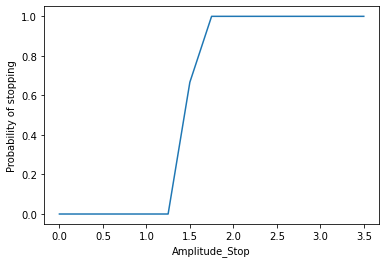

In [46]:
plt.plot(ampl_values, percentage)
plt.xlabel('Amplitude_Stop')
plt.ylabel('Probability of stopping')
plt.savefig('./Stop/'+'Amplitude-%_amploop'+'_'+str(seed)+'.png')
plt.show()

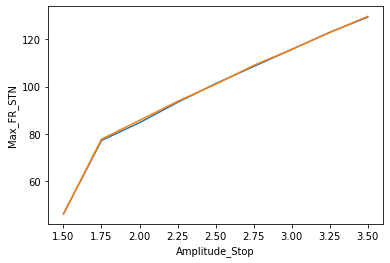

In [51]:
plt.plot(ampl_values[6:], meantrialsSTN_tot[6:])
plt.xlabel('Amplitude_Stop')
plt.ylabel('Max_FR_STN')
plt.savefig('./Stop/'+'Amplitude-mean_STN_amploop'+'_'+str(seed)+'.png')
plt.show()

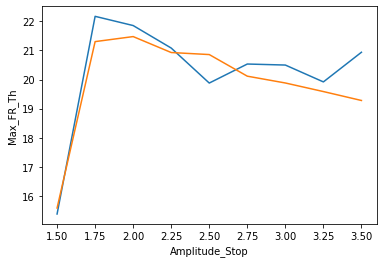

In [52]:
plt.plot(ampl_values[6:], meantrialsTh_tot[6:])
plt.xlabel('Amplitude_Stop')
plt.ylabel('Max_FR_Th')
plt.savefig('./Stop/'+'Amplitude-mean_Th_amploop'+'_'+str(seed)+'.png')
plt.show()

In [ ]:
#quitar if decision = stop -- no tiene mucho sentido....

In [ ]:
#max_STN_aux = []
#max_STN_aux.append(np.max(popfreqs[0].iloc[:,2]))
#max_STN_aux.append(np.max(popfreqs[0].iloc[:,3]))
#fr_max_STN.append(np.max(max_STN_aux)) 
#max_Th_aux = []
#max_Th_aux.append(np.max(popfreqs[0].iloc[:,12]))
#max_Th_aux.append(np.max(popfreqs[0].iloc[:,13]))
#fr_max_Th.append(np.max(max_Th_aux))

In [53]:
meantrialSTN = []
meantrialTh = []
meantrialSTN_tot = []
meantrialTh_tot = []

for i in range(0, len(datatables[0].stimulusstarttime)):
    if datatables[0].iloc[i]['decision'] == 'stop':
        meantrialSTN.append([np.mean(results[0]['popfreqs'][2][datatables[0].stimulusstarttime[i]+40:datatables[0].decisiontime[i]]), np.mean(results[0]['popfreqs'][3][datatables[0].stimulusstarttime[i]+40:datatables[0].decisiontime[i]])])
        meantrialTh.append(np.mean(results[0]['popfreqs'][12][datatables[0].stimulusstarttime[i]+40:datatables[0].decisiontime[i]]), (np.mean(results[0]['popfreqs'][13][datatables[0].stimulusstarttime[i]+40:datatables[0].decisiontime[i]]))     
        
meantrialSTN_tot = np.mean(meantrialSTN)
meantrialTh_tot = np.mean(meantrialTh)

SyntaxError: closing parenthesis ')' does not match opening parenthesis '[' (<ipython-input-53-bfdd2f511e50>, line 8)

### 1.3 General 

In [10]:
#See init_params.py / generateepochs.py / popconstruct.py / qvalues.py
#to know the parameters contained in each of the following variables 
environment = {
    'params': None, #neuron parameters (init_params.py)
    'pops': None,   #population parameters (init_params.py)
    'receps' : None, #receptor parameters (init_params.py)
    'base' : None, #baseline stimulation parameters (init_params.py)
    'dpmns' : None, #dopamine related parameters (init_params.py)
    'd1' : None, #D1-MSNs population related parameters (init_params.py)
    'd2' : None, #D2-MSNs population related parameters (init_params.py)
    'channels' : pd.DataFrame([["left"],["right"]], columns=['action']), #action channels related parameters (init_params.py)
    #'actionchannels' : pd.DataFrame([[1],[2]], columns=['action']), #labels for the actions (init_params.py)
    #'actionchannels' : pd.DataFrame([["left"],["right"]], columns=['action']), #labels for the actions (init_params.py)
    'newpathways' : None, #connectivity parameters (popconstruct.py)
    'Q_support_params': None, #initialization of Q-values update (qvalues.py) 
    'Q_df':None, #initialized Q-values df (qvalues.py)  
    'n_trials': 2, #number of trials (generateepochs.py)
    'volatility': 1, #frequency of changepoints (generateepochs.py)
    'conflict': 0.7, #probability of the preferred choice (generateepochs.py)
    'reward_mu': 1, #mean for the magnitude of the reward (generateepochs.py)
    'reward_std': 0.1, #std for the magnitude of the reward (generateepochs.py)
    'maxstim': 3.5, # 3 instead? how much stimulus the LIP gets at maximum
    'sustainedfraction': 0.75,
    'stop_signal_present': True,
    'stop_signal_probability': 1.0, #probability of trials that will get the stop signal / list of trial numbers
    'stop_signal_amplitude': 2.75, #amplitude #amplitude of the stop signal over base line
    'stop_signal_onset': 40., #in ms #antes 200
    'stop_signal_channel': "all", #"all" (all channels are given the stop signal) 
                                #/"any" (channel given the stop signal is chosen randomly)
                                # [list of channels] == subset of channels given the stop signal
    
}

In [11]:
results = cbgt.ExecutionManager(cores=7).run([pl]*1,[environment]*1)

(pid=3908) cp_idx [0 1 1 1]
(pid=3908) cp_idx [0 1 1 1]
(pid=3908) begin GenStopSchedule
(pid=3908) cp_idx [0 1 1 1]
(pid=3908) cp_idx [0 1 1 1]
(pid=3908) begin GenStopSchedule
(pid=3908) <class 'float'>
(pid=3908) [0 1]
(pid=3908) stop_df
(pid=3908)    stop_signal_present  stop_signal_probability stop_signal_channel
(pid=3908) 0                 True                      1.0                 all
(pid=3908) stop_channels_df
(pid=3908) <class 'float'>
(pid=3908) [0 1]
(pid=3908) stop_df
(pid=3908)    stop_signal_present  stop_signal_probability stop_signal_channel
(pid=3908) 0                 True                      1.0                 all
(pid=3908) stop_channels_df
(pid=3908)    left  right  trial_num
(pid=3908) 0  True   True          0
(pid=3908) 1  True   True          1
(pid=3908)    left  right  trial_num
(pid=3908) 0  True   True          0
(pid=3908) 1  True   True          1
(pid=3908) q_support None
(pid=3908) q_support None
(pid=3908) 2 4 0.161666`
(pid=3908) 2 4 0.161666`


(pid=3908) 0 stopsignal_applied [1. 0.]
(pid=3908) 0 agent.ramping_stopstim_target [7.2  4.45]
(pid=3908) 0 agent.stoptimer 40
(pid=3908) 0 trial_wise_stop_amplitude 2.75
(pid=3908) 0 trial_wise_stop_onset 40.0
(pid=3908) 0 agent.phase 0
(pid=3908) 0 stopsignal_applied [1. 1.]
(pid=3908) 0 agent.ramping_stopstim_target [7.2 7.2]
(pid=3908) 0 agent.stoptimer 40
(pid=3908) 0 trial_wise_stop_amplitude 2.75
(pid=3908) 0 trial_wise_stop_onset 40.0
(pid=3908) 0 agent.phase 0
(pid=3908) 0 stopsignal_applied [1. 0.]
(pid=3908) 0 agent.ramping_stopstim_target [7.2  4.45]
(pid=3908) 0 agent.stoptimer 40
(pid=3908) 0 trial_wise_stop_amplitude 2.75
(pid=3908) 0 trial_wise_stop_onset 40.0
(pid=3908) 0 agent.phase 0
(pid=3908) 0 stopsignal_applied [1. 1.]
(pid=3908) 0 agent.ramping_stopstim_target [7.2 7.2]
(pid=3908) 0 agent.stoptimer 40
(pid=3908) 0 trial_wise_stop_amplitude 2.75
(pid=3908) 0 trial_wise_stop_onset 40.0
(pid=3908) 0 agent.phase 0
(pid=3908) phasetimer 1001
(pid=3908) globaltimer 29

In [12]:
results[0].keys()

dict_keys(['params', 'pops', 'receps', 'base', 'dpmns', 'd1', 'd2', 'channels', 'newpathways', 'Q_support_params', 'Q_df', 'n_trials', 'volatility', 'conflict', 'reward_mu', 'reward_std', 'maxstim', 'sustainedfraction', 'stop_signal_present', 'stop_signal_probability', 'stop_signal_amplitude', 'stop_signal_onset', 'stop_signal_channel', 'actionchannels', 'volatile_pattern', 'cp_idx', 'cp_indicator', 'noisy_pattern', 't_epochs', 'block', 'stop_df', 'stop_channels_df', 'stop_amplitude_df', 'stop_onset_df', 'trial_num', 'chosen_action', 'celldefaults', 'popspecific', 'receptordefaults', 'basestim', 'dpmndefaults', 'd1defaults', 'd2defaults', 'popdata', 'pathways', 'connectivity_AMPA', 'meaneff_AMPA', 'plastic_AMPA', 'connectivity_GABA', 'meaneff_GABA', 'plastic_GABA', 'connectivity_NMDA', 'meaneff_NMDA', 'plastic_NMDA', 'AMPA_con', 'AMPA_eff', 'GABA_con', 'GABA_eff', 'NMDA_con', 'NMDA_eff', 'agent', 'datatables', 'reward_val', 'popfreqs'])

In [13]:
results[0]['Q_df']

,left,right
0,0.5,0.5
0,0.5,0.5
0,0.5,0.5


In [17]:
results[0]['stop_signal_amplitude']

2.75

In [18]:
results[0]['n_trials']

2

In [19]:
cbgt.saveResults(results, data_dir+'stop_data_amp_time'+str(results[0]['stop_signal_amplitude'])+'_'+str(results[0]['stop_signal_onset']),['popfreqs','popdata'])

In [20]:
datatables = cbgt.collateVariable(results,'datatables')
datatables[0]

,decision,stimulusstarttime,decisiontime,decisionduration,decisiondurationplusdelay,rewardtime,correctdecision,reward
0,stop,0,1001,1001,1302,1302,right,0
1,stop,1903,2904,1001,1302,3205,left,0


In [21]:
percentage = []
stop_number = 0
for i in datatables[0].index:
    if datatables[0].iloc[i]['decision'] == 'stop': 
        stop_number += 1
print(stop_number)
percentage.append(stop_number/results[0]['n_trials'])
print(percentage)

2
[1.0]


In [52]:
meantrialSTN = []
meantrialTh = []
meantrialsSTN_tot = []
meantrialsTh_tot = []

for i in range(0, len(datatables[0].stimulusstarttime)):
    if datatables[0].iloc[i]['decision'] == 'stop':
        meantrialSTN.append([np.mean(results[0]['popfreqs'][2][datatables[0].stimulusstarttime[i]+40:datatables[0].decisiontime[i]]), np.mean(results[0]['popfreqs'][3][datatables[0].stimulusstarttime[i]+40:datatables[0].decisiontime[i]])])
        meantrialTh.append([np.mean(results[0]['popfreqs'][12][datatables[0].stimulusstarttime[i]+40:datatables[0].decisiontime[i]]), (np.mean(results[0]['popfreqs'][13][datatables[0].stimulusstarttime[i]+40:datatables[0].decisiontime[i]]))])     

meantrialsSTN_tot = np.mean(meantrialSTN, axis = 0)
meantrialsTh_tot = np.mean(meantrialTh, axis = 0)

In [53]:
meantrialsSTN_tot

array([108.83220025, 109.0979304 ])

In [54]:
meantrialSTN

[[108.87577754653717, 109.07947739623098],
 [108.78862296219238, 109.11638339692443]]

In [55]:
meantrialTh

[[20.522603769221924, 20.71037114117234],
 [20.908313099780326, 19.764365822638467]]

In [56]:
meantrialsTh_tot

array([20.71545843, 20.23736848])

In [ ]:
results[0]["stop_df"]

In [ ]:
results[0]["stop_amplitude_df"]

In [ ]:
results[0]["stop_onset_df"]

In [ ]:
results[0]["stop_channels_df"]

In [26]:
popfreqs = cbgt.collateVariable(results,'popfreqs')

In [ ]:
max_STN = []
max_STN.append([np.max(popfreqs[0].iloc[:,2]), np.max(popfreqs[0].iloc[:,3])]) #left and right

In [ ]:
max_STN

In [ ]:
max_Th = []
max_Th.append([np.max(popfreqs[0].iloc[:,12]), np.max(popfreqs[0].iloc[:,13])]) #left and right 

In [ ]:
max_Th

In [ ]:
firing_rates, q_df, performance, rt_distribution, total_performance = plt_help.extract_relevant_frames(results,seed)

In [28]:
results[0]['popdata']

,name,action,N,C,Taum,RestPot,ResetPot,Threshold,RestPot_ca,Alpha_ca,...,dpmn_APRE,dpmn_APOST,dpmn_XPRE,dpmn_XPOST,dpmn_type,dpmn_alphaw,dpmn_a,dpmn_b,dpmn_c,column
0,GPi`,left`,75`,0.5`,20`,-70`,-55`,-50`,-85`,0.5`,...,nan`,nan`,nan`,nan`,nan`,nan`,nan`,nan`,nan`,0
1,GPi`,right`,75`,0.5`,20`,-70`,-55`,-50`,-85`,0.5`,...,nan`,nan`,nan`,nan`,nan`,nan`,nan`,nan`,nan`,1
2,STNE`,left`,750`,0.5`,20`,-70`,-55`,-50`,-85`,0.5`,...,nan`,nan`,nan`,nan`,nan`,nan`,nan`,nan`,nan`,2
3,STNE`,right`,750`,0.5`,20`,-70`,-55`,-50`,-85`,0.5`,...,nan`,nan`,nan`,nan`,nan`,nan`,nan`,nan`,nan`,3
4,GPeP`,left`,750`,0.5`,20`,-70`,-55`,-50`,-85`,0.5`,...,nan`,nan`,nan`,nan`,nan`,nan`,nan`,nan`,nan`,4
5,GPeP`,right`,750`,0.5`,20`,-70`,-55`,-50`,-85`,0.5`,...,nan`,nan`,nan`,nan`,nan`,nan`,nan`,nan`,nan`,5
6,D1STR`,left`,75`,0.5`,20`,-70`,-55`,-50`,-85`,0.5`,...,0.0`,0.0`,0.0`,0.0`,1`,18.333333333333332`,1.0`,0.1`,0.05`,6
7,D1STR`,right`,75`,0.5`,20`,-70`,-55`,-50`,-85`,0.5`,...,0.0`,0.0`,0.0`,0.0`,1`,18.333333333333332`,1.0`,0.1`,0.05`,7
8,D2STR`,left`,75`,0.5`,20`,-70`,-55`,-50`,-85`,0.5`,...,0.0`,0.0`,0.0`,0.0`,2`,-15.0`,0.5`,0.005`,0.05`,8
9,D2STR`,right`,75`,0.5`,20`,-70`,-55`,-50`,-85`,0.5`,...,0.0`,0.0`,0.0`,0.0`,2`,-15.0`,0.5`,0.005`,0.05`,9


In [34]:
results[0]['popfreqs'][2][datatables[0].stimulusstarttime[i]+40:datatables[0].decisiontime[i]]

40       25.644444
41       25.488889
42       25.200000
43       25.511111
44       25.711111
           ...    
996     113.022222
997     112.800000
998     113.000000
999     113.088889
1000    112.888889
Name: 2, Length: 961, dtype: float64

In [ ]:
#You can smoothen the FR by sending smooth=True, default: smooth=False
#plt_func.plot_fr(results[0],smooth=True)
plt_func.plot_fr_stop_zoom(firing_rates, results[0]['stop_signal_amplitude'], results[0]['stop_signal_onset'])

In [ ]:
plt_func.plot_fr_stop(firing_rates, results[0]['stop_signal_amplitude'], results[0]['stop_signal_onset'])

In [ ]:
import seaborn as sns
col_order = ["D1STR", "GPeP", "GPi","D2STR", "STNE", "Th", "Cx","CxI","FSI"] # To ease comparison with reference Figure 
                 
for i in np.arange(len(results)):
    g1 = sns.relplot(x="Time (ms)", y ="firing_rate", hue="channel",col="nuclei",data=results[i],col_wrap=3,kind="line",facet_kws={'sharey': False, 'sharex': True},col_order=col_order)
    g1.set(xlim = (0, 2000))
    g1.set(ylim = (0, 1))


In [ ]:
popfreqs = cbgt.collateVariable(results,'popfreqs')

In [ ]:
popdata = cbgt.collateVariable(results,'popdata')

In [ ]:
plt.plot(popfreqs[0].iloc[:,12])
plt.plot(popfreqs[0].iloc[:,13])
plt.xlim(0, 3500)
plt.xlabel('Time')
plt.ylabel('[Hz]')
plt.savefig('./Stop/'+'Th_activity_amp/time'+str(results[0]['stop_signal_amplitude'])+'_'+results[0]['stop_signal_onset']+'.png')
plt.show()

In [ ]:
plt.plot(popfreqs[0].iloc[:,2])
plt.plot(popfreqs[0].iloc[:,3])
plt.xlim(0, 3500)
plt.xlabel('Time')
plt.ylabel('[Hz]')
plt.savefig('./Stop/'+'STN_activity_amp/time'+str(results[0]['stop_signal_amplitude'])+'_'+results[0]['stop_signal_onset']+'.png')
plt.show()